In [275]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.preprocessing.sequence import pad_sequences

# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# from tensorflow.contrib import learn
from sklearn.metrics import mean_squared_error, mean_absolute_error

# import other packages

In [219]:
Fs = 100
f = 5
sample = 1000
x = np.arange(sample)
y = np.sin(2 * np.pi * f * x / Fs)

In [304]:
# create fake data
df = pd.DataFrame(y)
df.columns = ['f1']
df.index = rng = pd.date_range('1/1/2017', periods=df.shape[0], freq='1s')

# transform data into lstm inputs
def rnn_data(inp, out, look_back = 0, look_ahead = 0):
    xraw = inp.values
    yraw = out.values
#     print(xraw.shape, yraw.shape)
    xdata, ydata = [], []
    for i in range(len(xraw)-look_back-look_ahead-1):
        a = xraw[i:(i+look_back+1),:]
        xdata.append(a)
#     print(a.shape)
    for i in range(len(yraw)-look_back-look_ahead-1):
        a = yraw[(i+look_back+1):(i+look_back+look_ahead+2),:]
        ydata.append(a)
#     print(a.shape)
    
    xdata = np.array(xdata)
    ydata = np.array(ydata)
#     print(xdata.shape, ydata.shape)
    assert(len(xdata.shape)==3)
    assert(xdata.shape[0] == inp.shape[0]-look_ahead-look_back-1)
    assert(xdata.shape[2] == inp.shape[1])
    assert(xdata.shape[1]==look_back+1)
    assert(len(ydata.shape)==3)
    assert(ydata.shape[0] == out.shape[0]-look_ahead-look_back-1)
    assert(ydata.shape[2] == out.shape[1])
    assert(ydata.shape[1] == look_ahead+1)
    
#     if ydata.shape[2]==1:
#         ydata = ydata.squeeze(axis=2)
    
    return xdata, ydata

xdata, ydata = rnn_data(df[['f1']], df[['f1','f1']], 10, 20)
print(xdata.shape, ydata.shape)

(969, 11, 1) (969, 21, 2)


In [305]:
mlen = max(xdata.shape[1], ydata.shape[1])
xdata = pad_sequences(xdata, mlen, padding='post', dtype='float32')
ydata = pad_sequences(ydata, mlen, padding='pre', dtype='float32')

In [308]:
# build keras model
model = Sequential()
model.add(LSTM(input_shape=(xdata.shape[1], xdata.shape[2]), units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(ydata.shape[2]))
model.add(Activation("linear"))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_77 (LSTM)               (None, 21, 50)            10400     
_________________________________________________________________
dropout_68 (Dropout)         (None, 21, 50)            0         
_________________________________________________________________
lstm_78 (LSTM)               (None, 21, 100)           60400     
_________________________________________________________________
dropout_69 (Dropout)         (None, 21, 100)           0         
_________________________________________________________________
dense_41 (Dense)             (None, 21, 2)             202       
_________________________________________________________________
activation_27 (Activation)   (None, 21, 2)             0         
Total params: 71,002
Trainable params: 71,002
Non-trainable params: 0
_________________________________________________________________


In [294]:
# train model on data
model.fit(xdata, ydata, epochs=1, batch_size=1, validation_split=0.1)

Train on 872 samples, validate on 97 samples
Epoch 1/1
872/872 [==============================] - 36s - loss: 0.0597 - val_loss: 0.0264


In [295]:
# evaluate model on test data
ypred = model.predict(xdata)

In [265]:
# plot results
# mean_squared_error(ypred, ydata)

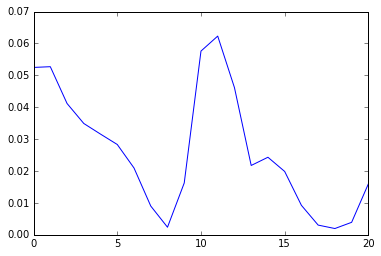

In [301]:
plt.plot(np.mean(np.power(ydata-ypred,2),axis=0))

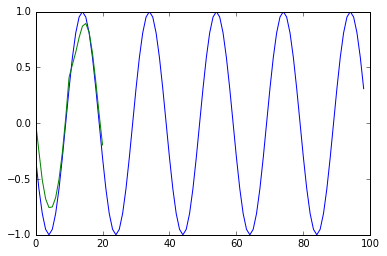

In [300]:
plt.plot(xdata[1:100,10,0])
plt.plot(ypred[0,:,0])
# plt.plot(ypred[0,:,1])